<a href="https://colab.research.google.com/github/larrygoyeau/bubble_segmentation_Unet/blob/master/Unet_automatic_segementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bubble segementation using Unet: inference model

In [1]:
#@title If you use google colab, first click on "ouvrir en mode brouillon" ("open in playground") on the upper panel and run this block (click on this text and Ctrl+Entre). This will install the framwork. { run: "auto" }

#To fix the version of tensorflow:
%tensorflow_version 1.x

import logging
logging.getLogger('tensorflow').disabled = True

# Install required libs
import os
os.system('pip install albumentations==0.4.5')
os.system('pip install -U efficientnet==1.0.0')
os.system('pip install image-classifiers==1.0.0')
os.system('pip install -U segmentation-models==1.0.0')

import sys
import random
from google.colab import files
import cv2
import keras
from keras.models import model_from_json
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import segmentation_models as sm
import resource
from google_drive_downloader import GoogleDriveDownloader as gdd
from IPython.display import HTML, Image, clear_output
from google.colab.output import eval_js
from base64 import b64decode
import copy

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 10))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    
    def __init__(
            self, 
            image=None,
            images_dir=None,
            preprocessing=None,
            augmentation=None,
    ):
        self.ids_image = os.listdir(images_dir)
        
        if images_dir!=None:
          self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids_image]
        else:
          self.images_fps=None
   
        self.preprocessing = preprocessing

        self.augmentation=augmentation

        self.image=image
    
    def __getitem__(self, i):
        
        # read data
        if self.images_fps!=None:
          image = cv2.imread(self.images_fps[i])
        else:
          image = self.image
        if len(image)>2**11:
          image=image[:2**11,:]
        if len(image[0])>2**11:
          image=image[:,:2**11]
        shape_image=image.shape
        p=255/(image.max()-image.min())
        image=(image-image.min())*p
        image= image.astype(np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.augmentation:
          I=len(image)
          J=len(image[0])
          sample = self.augmentation(I,J)(image=image)
          image = sample['image']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image= sample['image']
            
        return image, shape_image


def get_validation_augmentation(I,J):
    """Add paddings: Unet accept only image with size of power of 2 or 384*544"""
    if I>384 or J>544:
      test_transform = [A.PadIfNeeded(2**(int(np.log(I-1)/np.log(2))+1), 2**(int(np.log(J-1)/np.log(2))+1), border_mode=0)]
    else:
      test_transform = [A.PadIfNeeded(384, 544, border_mode=0)]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callbale): data normalization function 
    Return:
        transform function
    """
    return A.Lambda(image=preprocessing_fn)

BACKBONE = 'efficientnetb3'
preprocess_input = sm.get_preprocessing(BACKBONE)
LR = 0.0001

# define network parameters
n_classes =3 # 2+1 for the background
activation = 'softmax'

# define optimizer
optim = keras.optimizers.Adam(LR)

# Download trained weights from releases if needed
###### Important: If you want to change the trained model, replace the file_id below.
###### For example if your shared link is https://drive.google.com/file/d/16m6o97REebp_C86IbjbaHitxUvjBjrBe/view?usp=sharing
###### the file_id will be 16m6o97REebp_C86IbjbaHitxUvjBjrBe

gdd.download_file_from_google_drive(file_id='1-1ot0U_PFeSs9pdpIbd3RoTOrxrOzxnb',
                                    dest_path='/content/model.json',
                                    unzip=False)
json_file = open('/content/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

MODEL_PATH = '/content/model.h5'
gdd.download_file_from_google_drive(file_id='1fGFApwvmk64gmpmyEm_GNYb-YEP3fSt4',
                                    dest_path=MODEL_PATH,
                                    unzip=False)

model.load_weights(MODEL_PATH)

# compile keras model with defined optimozer, loss and metrics
model.compile(optim,loss='categorical_crossentropy')

# To increas the recursion limite
resource.setrlimit(resource.RLIMIT_STACK, [0x100000000, resource.RLIM_INFINITY])
sys.setrecursionlimit(0x1000000)

def color_bubble(mask,i,j,I,J,random_color,color):
  '''Color the bubble that contain the point (i,j) in color 'random_color' '''
  if all(mask[i,j]==color) and (i,j)!=(0,0):
    if i==I-1 or j==J-1 or i==0 or j==0:
      mask[0,0][1]=mask[0,0][1]+1 #number of pixel in contacte with the border
    mask[0,0][0]=mask[0,0][0]+1   #size bubble
    mask[i,j]=random_color
    if 0<j:
      color_bubble(mask,i,j-1,I,J,random_color,color)
    if i<I-1:
      color_bubble(mask,i+1,j,I,J,random_color,color)
    if 0<i:
      color_bubble(mask,i-1,j,I,J,random_color,color)
    if j<J-1:
      color_bubble(mask,i,j+1,I,J,random_color,color)
    
def uncolor_bubble(mask,i,j,I,J,color_liquide,random_color):
  '''Remouve the bubble that contain (i,j) of color random_color'''
  if all(mask[i,j]==random_color):
    mask[i,j]=color_liquide
    if 0<j:
      uncolor_bubble(mask,i,j-1,I,J,color_liquide,random_color)
    if i<I-1:
      uncolor_bubble(mask,i+1,j,I,J,color_liquide,random_color)
    if 0<i:
      uncolor_bubble(mask,i-1,j,I,J,color_liquide,random_color)
    if j<J-1:
      uncolor_bubble(mask,i,j+1,I,J,color_liquide,random_color)
    
# The fonuction bellow select a good color for bubble

threshold_red=30

def the_color(random_color,threshold):
  '''This function return a color which is not too clear, not too dark, not too red (red is reserved for manually anotated bubble)'''
  if (random_color[0]-random_color[1]<threshold and random_color[0]-random_color[2]<threshold) or (255-threshold_red<random_color[0] and random_color[1]<threshold_red and random_color[2]<threshold_red):
    random_color=[random.randint(2, 255),random.randint(2, 255),random.randint(2, 255)]
    return(the_color(random_color,threshold))
  else:
    return(random_color)
    
# The fonuction bellow will color each bubbles and return the size of each bubbles

def foam(mask,color_air,threshold,color_liquide,image_name,remove_bubbles_on_the_border):
  '''This function will color each bubble in a different color, count the number of bubble and save the size of each bubble.
  If remove_bubbles_on_the_border is true, the bubble that are in contact with the outline of the images are removed'''
  file = open(image_name[:-4]+".txt","w")
  file.write("Bubble index and its size\n")
  I=len(mask)
  J=len(mask[0])
  bubble=0
  size_of_bubbles=[]
  for i in range(I):
    for j in range(J):
      if all(mask[i,j]==color_air):
        mask[0,0][0]=0 #size of bubbles
        mask[0,0][1]=0 #number of pixel in contacte with the border
        random_color=[random.randint(2, 255),random.randint(2, 255),random.randint(2, 255)]
        random_color=the_color(random_color,60)
        color_bubble(mask,i,j,I,J,random_color,color_air)
        size_bubble=int(mask[0,0][0])
        if size_bubble<threshold: #Remove bubbles that are too small
          uncolor_bubble(mask,i,j,I,J,color_liquide,random_color)
        elif mask[0,0][1]>0 and remove_bubbles_on_the_border:
          uncolor_bubble(mask,i,j,I,J,color_liquide,random_color)
        else:
          size_of_bubbles=size_of_bubbles+[size_bubble]
          file.write(str(bubble)+"  "+str(size_bubble)+"\n")
          bubble=bubble+1
  file.close() 
  print("Number of detected bubbles "+str(bubble))
  return(size_of_bubbles)

def segment_image(uploaded,remove_bubbles_on_the_border):
  '''Segment, count, and save the bubbles detected'''
  size_of_bubbles=[]
  size_images=[]
  images_list_color=[]
  
  for image_uploaded in uploaded:
    print('\n')
    path=os.path.join('/content', image_uploaded)
    image=cv2.imread(path)
    size_images=size_images+[image.shape[0]*image.shape[1]]
    original_image=cv2.imread(path)
    p=255/(original_image.max()-original_image.min())
    original_image=(original_image-original_image.min())*p
    original_image= original_image.astype(np.uint8)
    images_list_color=images_list_color+[original_image]
    path=path.replace(' ', '\ ')
    os.system('rm '+path)

    test_dataset = Dataset(
      image=image,
      preprocessing=get_preprocessing(preprocess_input),
      augmentation=get_validation_augmentation
    )

    image, shape_image= test_dataset[0]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()[0]
    
    image=image[0]
    image=image[int((len(image)-shape_image[0])/2):int((len(image)-shape_image[0])/2)+shape_image[0]]
    image=image[:,int((len(image[0])-shape_image[1])/2):int((len(image[0])-shape_image[1])/2)+shape_image[1]]
    pr_mask=pr_mask[int((len(pr_mask)-shape_image[0])/2):int((len(pr_mask)-shape_image[0])/2)+shape_image[0]]
    pr_mask=pr_mask[:,int((len(pr_mask[0])-shape_image[1])/2):int((len(pr_mask[0])-shape_image[1])/2)+shape_image[1]]
    size_of_bubbles=size_of_bubbles+foam(pr_mask[:,:-1], color_air=[1,0,0],threshold=threshold,color_liquide=[0,1,0], image_name=image_uploaded, remove_bubbles_on_the_border=remove_bubbles_on_the_border)
    
    image=denormalize(image.squeeze())
    I=len(image)
    J=len(image[0])
    mask_plus_image=pr_mask.copy()
    mask=pr_mask.copy()
    for i in range(I):
      for j in range(J):
        if pr_mask[i,j][2]==1.0 or pr_mask[i,j][1]==1.0 or all(pr_mask[i,j]==0) or pr_mask[i,j][0]==1.0:
          mask_plus_image[i,j]=image[i,j]*255
          mask[i,j]=255
    
    visualize(mask_plus_image=denormalize(mask_plus_image.squeeze()))
    cv2.imwrite('mask_plus_'+image_uploaded[:-3]+'png', mask_plus_image)
    cv2.imwrite('mask_of_'+image_uploaded[:-3]+'png', mask)
  return(size_of_bubbles,size_images,images_list_color)


#The following functions will create the interface for the hand drawing.

canvas_html = """
<canvas width=%d height=%d></canvas>
<br>
<button>Next image</button>
<button onclick="undo()">Undo</button>
<button onclick="Remove_bubble()">Remove bubbles</button>
<button onclick="Add_bubble()">Add bubbles</button>
<p>Brush size:</p>
<input name="brush" id="brush_size" type="range" value="0"  min="0" max="20" />
<p>Zoom:</p>
<input name="Zoom" id="Zoom" type="range" value="%d"  min="1" max="6" />

<style>
canvas {
  image-rendering: pixelated;
}
</style>

<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

s = Zoom.value;
canvas.style.width = s*canvas.width+'px'
canvas.style.height = s*canvas.height+'px'
Zoom.oninput = function() {
  s = Zoom.value;
  canvas.style.width = s*canvas.width+'px'
  canvas.style.height = s*canvas.height+'px'
}

var button = document.querySelector('button')
ctx.strokeStyle='#ff0000';

var cPushArray = new Array();

var cStep = -1;
function undo() {
    if (cStep > 0) {
        cStep--;
        var canvasPic = new Image();
        canvasPic.src = cPushArray[cStep];
        canvasPic.onload = function () { ctx.drawImage(canvasPic, 0, 0); }
        list_of_remove.pop()
    }
}
function cPush() {
    cStep++;
    if (cStep < cPushArray.length) { cPushArray.length = cStep; }
    cPushArray.push(canvas.toDataURL());
}

const imageData = ctx.createImageData(canvas.width, canvas.height);
var image = %s;
var original_image= %s;
var mask = %s;
// Iterate through every pixel
k=0
for (let i = 0; i < imageData.data.length; i += 4) {
  // Modify pixel data
  imageData.data[i + 0] = image[i-k];  // R value
  imageData.data[i + 1] = image[i+1-k];    // G value
  imageData.data[i + 2] = image[i+2-k];  // B value
  imageData.data[i + 3] = 255;  // A value
  k=k+1
}

// Draw image data to the canvas
ctx.putImageData(imageData,0,0);

function Add_bubble() {
var mouse = {x: 0, y: 0}
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})

brush_size.oninput = function() {
  ctx.lineWidth = brush_size.value;
}

canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(Math.trunc(1/s*mouse.x)+0.5,Math.trunc( 1/s*mouse.y)+0.5)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
k=0
cPush()
var onPaint = ()=>{
  if (k/50==Math.trunc(k/50)){
    cPush()
  }
  ctx.lineTo(Math.trunc(1/s*mouse.x)+0.5, Math.trunc(1/s*mouse.y)+0.5)
  ctx.stroke()
  k++
}
}

Add_bubble()

list_of_remove=[]
function Remove_bubble() {
  function uncolor_bubble(x,y,color_bubble,color_liquide){
    if (mask[y*canvas.width*3+0+x*3]==color_bubble && mask[y*canvas.width*3+0+x*3]!=color_liquide){
      r=original_image[y*canvas.width*3+0+x*3]
      g=original_image[y*canvas.width*3+1+x*3]
      b=original_image[y*canvas.width*3+2+x*3]
      ctx.fillStyle = "rgba("+r+","+g+","+b+","+255+")"
      ctx.fillRect( x, y, 1, 1 )
      mask[y*canvas.width*3+0+x*3]=color_liquide
      if (0<y){
        uncolor_bubble(x,y-1,color_bubble,color_liquide)}
      if (0<x){
        uncolor_bubble(x-1,y,color_bubble,color_liquide)}
      if (x<canvas.width-1){
        uncolor_bubble(x+1,y,color_bubble,color_liquide)}
      if (y<canvas.height-1){
        uncolor_bubble(x,y+1,color_bubble,color_liquide)}
      }
    }
  cPush()
  canvas.onmousedown = ()=>{
    var x = Math.trunc(1/s*(event.clientX-5))
    var y = Math.trunc(1/s*(event.clientY-7.5))
    list_of_remove.push([y,x])
    var copy_mask= [...mask]
    uncolor_bubble(x,y,mask[y*canvas.width*3+0+x*3],255)
    mask=copy_mask
    cPush()
  }
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve([list_of_remove,
      canvas.toDataURL('image/png',1)]
      )
  }
})
</script>
"""

def draw(image_flat, original_image_flat, mask_flat, filename='drawing.png', w=800, h=400, line_width=1,scale=4):
  '''Plot the image to be corrected by the user and save the final image'''
  display(HTML(canvas_html % (w, h,scale, image_flat, original_image_flat, mask_flat)))
  data = eval_js("data")
  binary = b64decode(data[1].split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return(data[0])

def size_and_add_bubble(image,i,j,I,J):
  '''Remove bubble that contain (i,j) and return its size'''
  if 255-threshold_red<image[i,j][2] and image[i,j][1]<threshold_red and image[i,j][0]<threshold_red:
    image[i,j]=0
    size=1
    if 0<j:
      size=size+size_and_add_bubble(image,i,j-1,I,J)
    if i<I-1:
      size=size+size_and_add_bubble(image,i+1,j,I,J)
    if 0<i:
      size=size+size_and_add_bubble(image,i-1,j,I,J)
    if j<J-1:
      size=size+size_and_add_bubble(image,i,j+1,I,J)
    return(size)
  else:
    return(0)

def size_and_remove_bubble(mask,i,j,I,J,color):
  '''Remouve the bubble that contain (i,j)'''
  if mask[i,j][0]==color[0] and mask[i,j][0]!=255:
    mask[i,j]=255
    size=1
    if 0<j:
      size=size+size_and_remove_bubble(mask,i,j-1,I,J,color)
    if i<I-1:
      size=size+size_and_remove_bubble(mask,i+1,j,I,J,color)
    if 0<i:
      size=size+size_and_remove_bubble(mask,i-1,j,I,J,color)
    if j<J-1:
      size=size+size_and_remove_bubble(mask,i,j+1,I,J,color)
    return(size)
  else:
    return(0)


def draw_missed_bubble(image_name,size_all_bubbles,original_image):
  '''Add the new bubbles to the mask and save its size'''
  image_path=os.path.join('/content','mask_plus_'+ image_name)
  mask_path=os.path.join('/content', 'mask_of_'+image_name[:-3]+'png')
  bubble_info_path=os.path.join('/content',  image_name[:-4]+".txt")
  image=cv2.imread(image_path)
  mask=cv2.imread(mask_path)
  I=len(image)
  J=len(image[0])
  image_flat=list(image.flatten())
  original_image_flat=list(original_image.flatten())
  mask_flat=list(mask.flatten())
  m=max(I,J/1.4)
  bubbles_to_remove=draw(image_flat, original_image_flat, mask_flat, image_path, w=J, h=I,scale=700/m)

  #Remouve bubbles

  for bubble in bubbles_to_remove:
    color=copy.copy(mask[bubble[0],bubble[1]])
    size_to_remove=size_and_remove_bubble(mask,bubble[0],bubble[1],I,J,color)
    already=False
    file = open(bubble_info_path,"r")
    lines = file.readlines()
    file.close()
    file = open(bubble_info_path,"w")
    for line in range(len(lines)):
      if lines[line]=='Bubble index and its size\n':
        file.write(lines[line])
      elif int(lines[line].split()[1])!=size_to_remove or already:
        file.write(str(line-1-int(already))+"  "+lines[line].split()[1]+"\n")
      else:
        already=True
    file.close()

    for size in range(len(size_all_bubbles)):
      if size_all_bubbles[size]==size_to_remove:
        del size_all_bubbles[size]
        break

  image=cv2.imread(image_path)
  #Add missed bubbles
  for i in range(I):
    for j in range(J):
      if 255-threshold_red<image[i,j][2] and image[i,j][1]<threshold_red and image[i,j][0]<threshold_red:
        mask[i,j]=[0,0,0]
  
  cv2.imwrite(mask_path,mask)

  #Add missed bubbles on the .txt file

  n_new_bubble=0
  file = open(bubble_info_path,"r")
  lines = file.readlines()
  file.close()
  n_bubble=len(lines)-1
  file = open(bubble_info_path,"a+")
  for i in range(I):
    for j in range(J):
      if 255-threshold_red<image[i,j][2] and image[i,j][1]<threshold_red and image[i,j][0]<threshold_red:
        size=size_and_add_bubble(image,i,j,I,J)
        size_all_bubbles=size_all_bubbles+[size]
        file.write(str(n_bubble+n_new_bubble)+"  "+str(size)+"\n")
        n_new_bubble=n_new_bubble+1
  file.close()

  return(size_all_bubbles)

remove_bubbles_on_the_border=False
threshold = 4

TensorFlow 1.x selected.


Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
#@title Do you want to remove the bubbles that are in contact with the outline of the images? { run: "auto" }

Select_the_answer_and_run_this_block = 'No' #@param ["Yes", "No"]

if Select_the_answer_and_run_this_block=='Yes':
  remove_bubbles_on_the_border=True
else:
  remove_bubbles_on_the_border=False

In [0]:
#@title To avoide noise, selecte the minimume size of bubbles in number of pixel. { run: "auto" }

threshold = 4 #@param {type:"integer"}


Now run the block below. Then click on “select fichiers” and select (several) images that you want to segment from your device. The segmented images are saved on the left panel 'fichier'. Click on 'actualliser' and the file will appear. These files are:


*   mask_plus_image_name.png $ $ $ $ for the segmentation plus the image
*   mask_of_image_name.png $ $ $ $ for the mask only
* image_name.txt $ $ $ $ for the description of each bubble detected on the image



 You can download these files by right clicking on them and select 'telecharger'.


Saving image_00001.jpg to image_00001.jpg


Number of detected bubbles 12


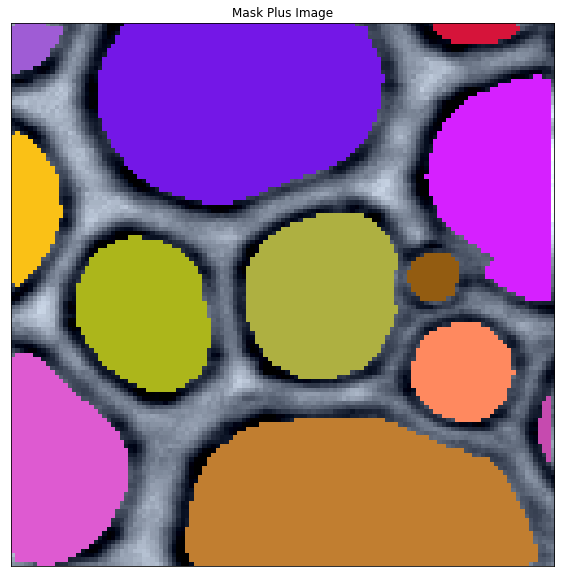

In [13]:
#@title Run this block { run: "auto" }

file_names = files.upload()
size_all_bubbles,size_images,images_list_color=segment_image(file_names,remove_bubbles_on_the_border)

# Manual modifications.
The below block allow you to add and remove bubbles on the previous automatic segmentation. To add a bubble you have to draw it with your mouse. To remove bubbles click on the button 'Remove bubbles' and click on the bubbles that you want to remove. When you finished click on 'next image' bellow the image.

In [14]:
#@title Run this block  { run: "auto" }
i=0
for image_name in file_names:
  size_all_bubbles=draw_missed_bubble(image_name[:-3]+'png',size_all_bubbles,images_list_color[i])
  i=i+1
  if len(file_names)>1:
    clear_output()

if len(file_names)>1:
  for image_name in file_names:
    print('your drawing apper in bleu')
    image_path=os.path.join('/content','mask_plus_'+ image_name)
    image=cv2.imread(image_path)
    visualize(mask_plus_image=denormalize(image.squeeze()))

# Aditional statistics on foam images
'size_all_bubbles' is the list of the size of all bubbles in all the images that you selected. By running the block below, you will get the distribution of the size. The historame is saved as size_distribution.png

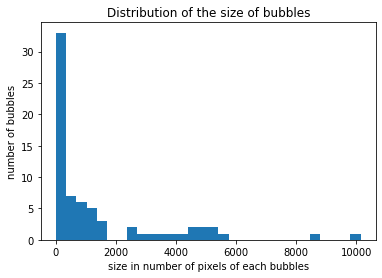

In [11]:
plt.hist(size_all_bubbles,bins = 30)
plt.xlabel('size in number of pixels of each bubbles')
plt.ylabel('number of bubbles')
plt.title('Distribution of the size of bubbles')
plt.savefig("/content/size_distribution.png")

In [0]:
if not remove_bubbles_on_the_border:
  print('The proportion of air is '+str(round(sum(size_all_bubbles)/sum(size_images),3)))

The proportion of air is 0.56


# Some useful instructions:

*  It's recomended to use a GPU to increas the speed of segmentation. You can check it on >>execution>>modifier le type d'execution>>accélérateur>>materiel>>GPU
*   If you want to have a look on the code, double click on blocks. Save a copy of this notbook to your drive and be free to add any code and functionalities!
*   This programme uses some libraries that are already installed in colab. This means that it may happen in the future that some update of these libraries became incompatible with the segmentation framework. If needed you can add at the top of the source code the line '!pip install 'name of the library'=='verssion of the required library'' . The versions of the required libraries are recorded in 'Package used for Unet.pdf' in [github](https://github.com/larrygoyeau/bubble_segmentation_Unet).
*   If you get some troubles, please contact me: larry.goyeau@gmail.com